In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import scipy as sp

In [2]:
def MonteCarloAsianFixedStrikeCall(S, K, r, sig, T, M, N):
    dt = T/N
    rdt = r*dt
    sigsdt = sig * np.sqrt(dt)
    
    S0 = 100
    np.random.seed(20220604)
    S = np.empty([M,N+1])
    rv = np.random.normal(r*dt,sigsdt,[M,N]) # Helps doing the brownian motion stock price
    
    for i in range(M): # i is initially 0 
        S[i,0] = S0
        for j in range(N):
            S[i,j+1] = S[i,j] * (1+rv[i,j])

    averages = []
    payoffs = []
    for i in range(M): # Each simulation
        quotent = 0
        total = 0
        dividend = 0
        runaverage = []
        for j in range(N+1): # How each simulation plays out, count price per scenario
            dividend += 1
            quotent = quotent + S[i,j]
        Sa = quotent/dividend # Average per each simulation
        payoffs.append(max((Sa - K), 0)*math.exp(-r*T))
    arithmetic_option_price = np.mean(payoffs)
    arith_std = np.std(payoffs)
    return (arithmetic_option_price, arith_std)

In [3]:
Arith10, std10 = MonteCarloAsianFixedStrikeCall(100, 100, 0, 0.2, 30/365, 10,30)

https://sheir.org/mf/geometric-asian-option/

In [4]:
def GeomAsianCall(S, K, r, sig, T):
    siga = sig/np.sqrt(3)
    sigatwo = siga**2
    a = 0.5*(r-sigatwo/6)
    d1 = (np.log(S*math.exp(a*T)/K)+(0.5*sigatwo)*T)/(siga/np.sqrt(T))
    d2=d1-siga*np.sqrt(T)
    return S*norm.cdf(d1)-K*norm.cdf(d2)


# CHECK IF IN LINE WITH http://uu.diva-portal.org/smash/get/diva2:301070/FULLTEXT01.pdf

In [5]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [188]:
def brownian_motion(N, M, r, T, sig, S0):
    dt = T/N
    rdt = r*dt
    sigsdt = sig * np.sqrt(dt)
    np.random.seed(100)

    
    price_sequence = np.empty([M,N+1])
    rv = np.random.normal(r*dt,sigsdt,[M,N])
    
    for i in range(M): # i is initially 0 
        price_sequence[i,0] = S0
        for j in range(N):
            price_sequence[i,j+1] = price_sequence[i,j] * (1+rv[i,j])
    return price_sequence

In [199]:
def MonteCarloAsianOption(S, K, r, sig, T, M, N):
    # Generate brownian motion and define some variables
    Si = brownian_motion(N, M, r, T, sig, S)
    S_avg = []
    Payoff = []
    
    # Perform the option price calculation
    for i in range(M):
        S_avg.append(np.mean(Si[i,:]))
        Payoff.append(np.maximum(S_avg[i] - K, 0)) # * np.exp(-r*T)) can't be here
        
    option_price = np.mean(Payoff) * np.exp(-r*T)
    return option_price

In [170]:
def MonteCarloAsianOptionPut(S, K, r, sig, T, M, N):
    # Generate brownian motion and define some variables
    Si = brownian_motion(N, M, r, T, sig, S)
    S_avg = []
    Payoff = []
    
    # Perform the option price calculation
    for i in range(M):
        S_avg.append(np.mean(Si[i,:]))
        Payoff.append(np.maximum(K - S_avg[i], 0) * np.exp(-r*T))
        
    option_price = np.mean(Payoff)
    return option_price

In [173]:
MonteCarloAsianOption(100, 100, 0, 0.2, 30/365, 10000, 30)

1.3466534438349775

In [174]:
MonteCarloAsianOptionPut(100, 100, 0, 0.2, 30/365, 10000, 30)

1.3125790066822272

## Variance reduction techniques for Monte Carlo simulations

Using a geometric control variate

http://uu.diva-portal.org/smash/get/diva2:301070/FULLTEXT01.pdf

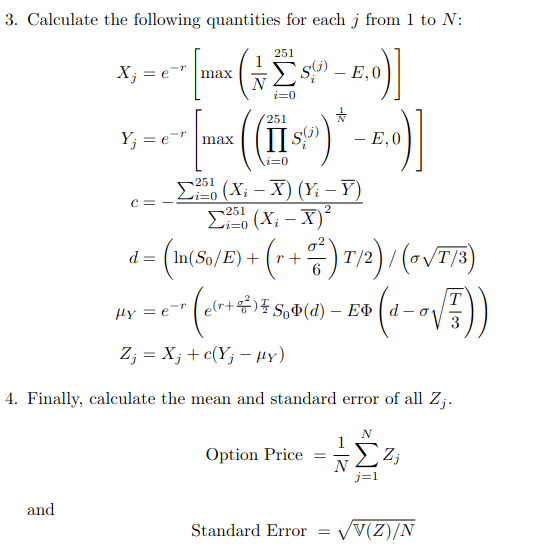

In [205]:
def MonteCarloGeomControlVariateCall(S0, K, r, sig, T, M, N):
    # Pre-define some variables to ease calculations
    dt = T/N
    rdt = r*dt
    sigsdt = sig * np.sqrt(dt)
    X = np.empty([M,N+1])
    Y = np.empty([M,N+1]) 
    S = brownian_motion(N, M, r, T, sig, S0)
    sigtwo = sig**2
    Yjs = []
    Xjs = []
    dd = (np.log(S0/K)+(r + sigtwo/6)*T/2)/(sig*np.sqrt(T/3))
    dstar = math.exp((r+sigtwo/6)*((T/2)))
    Uy = (dstar*S0*norm.cdf(dd) - K*norm.cdf(dd-sig*np.sqrt(T/3)))*math.exp(-r*T)

    # Run the simulations
    for i in range(M): # For each simulation
        quotent = 0
        product = 0
        total = 0
        dividend = 0
        xlist = []
        for j in range(N+1): # For each step in a simulation
            dividend += 1
            quotent = quotent + S[i,j]
            X[i,j] = quotent/dividend # Arithmetic
            if j == 0: # This prevents from multiplying with 0 in the first step
                product = 100
            else:
                product = product * S[i,j] 
            Y[i,j] = product**(1/(j+1))
        Xj = quotent/dividend # Arithaverage per each simulation
        Yj = product**(1/dividend) # Geomaverage of each simulation
        Xjs.append(max((Xj - K), 0)) # *math.exp(-r*T))
        Yjs.append(max((Yj - K), 0)) # *math.exp(-r*T))
    Xhat = np.mean(Xjs) * math.exp(-r*T)
    Yhat = np.mean(Yjs) * math.exp(-r*T)
    
    # Calculate C
    correlation = []
    for i in range(M):
        covariance = 0
        variance = 0
        for j in range(N+1):
            # Even here the correct Y[i,j] etc are printed
            covariance += (X[i,j] - Xhat)*(Y[i,j] - Yhat)
            variance += (X[i,j] - Xhat)**2
        c = (covariance/variance)*(-1)
        correlation.append(c)
        
    Zetas = np.empty([M,N+1])
    for i in range(M):
        for j in range(N+1):
            Zetas[i,j] = X[i,j] + correlation[i]*(Y[i,j] - Uy)
    controlvariate = np.mean(Zetas)
    control_std = np.std(Zetas)
    return (controlvariate, control_std)

In [175]:
# NOT CORRECT
def MonteCarloGeomControlVariatePut(S0, K, r, sig, T, M, N):
    # Pre-define some variables to ease calculations
    dt = T/N
    rdt = r*dt
    sigsdt = sig * np.sqrt(dt)
    X = np.empty([M,N+1])
    Y = np.empty([M,N+1]) 
    S = brownian_motion(N, M, r, T, sig, S0)
    sigtwo = sig**2
    Yjs = []
    Xjs = []
    dd = (np.log(S0/K)+(r + sigtwo/6)*T/2)/(sig*np.sqrt(T/3))
    dstar = math.exp((r+sigtwo/6)*((T/2)))
    Uy = (dstar*S0*norm.cdf(-dd))*math.exp(-r*T) - K*norm.cdf(-dd-sig*np.sqrt(T/3))

    # Run the simulations
    for i in range(M): # For each simulation
        quotent = 0
        product = 0
        total = 0
        dividend = 0
        xlist = []
        for j in range(N+1): # For each step in a simulation
            dividend += 1
            quotent = quotent + S[i,j]
            X[i,j] = quotent/dividend # Arithmetic
            if j == 0: # This prevents from multiplying with 0 in the first step
                product = 100
            else:
                product = product * S[i,j] 
            Y[i,j] = product**(1/(j+1))
        Xj = quotent/dividend # Arithaverage per each simulation
        Yj = product**(1/dividend) # Geomaverage of each simulation
        Xjs.append(max((K - Xj), 0)*math.exp(-r*T))
        Yjs.append(max((K - Yj), 0)*math.exp(-r*T))
    Xhat = np.mean(Xjs)
    Yhat = np.mean(Yjs)
    
    # Calculate C
    correlation = []
    for i in range(M):
        covariance = 0
        variance = 0
        for j in range(N+1):
            # Even here the correct Y[i,j] etc are printed
            covariance += (X[i,j] - Xhat)*(Y[i,j] - Yhat)
            variance += (X[i,j] - Xhat)**2
        c = (covariance/variance)*(-1)
        correlation.append(c)
        
    Zetas = np.empty([M,N+1])
    for i in range(M):
        for j in range(N+1):
            Zetas[i,j] = X[i,j] + correlation[i]*(Y[i,j] - Uy)
    controlvariate = np.mean(Zetas)
    control_std = np.std(Zetas)
    return (controlvariate, control_std)

In [177]:
MonteCarloGeomControlVariateCall(100, 100, 0, 0.2, 30/365, 10,30)

(1.342851745644346, 0.030049895376175625)

In [176]:
MonteCarloGeomControlVariatePut(100, 100, 0, 0.2, 30/365, 10,30)

(1.3878872493517211, 0.03009925781498924)

In [185]:
# Returns the average of each step as well as the last of each step.
def AverageSequence(Si):
    all_sequences = []
    S_avg = []
    # Loop through the multidimensional np array and make averages.
    for i in range(len(Si)):
        pricelist = []
        averages = []
        S_avg.append(np.mean(Si[i,:]))
        for j in range(len(Si[i])): # Si[i][j] is represents each price point in the loops
#             print("Current price ", Si[i][j])
            pricelist.append(Si[i][j])
            Sm = np.mean(pricelist)
#             print("Average", Sm)
            averages.append(Sm)
        all_sequences.append(averages)
#     print(S_avg)
    return (np.array(all_sequences), S_avg)